In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import csv
import math
import json
import ast
import cv2
import warnings
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Ignore warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.10f}'.format)

# Visualizations

In [9]:
# load the 4 files 
df_fin1=pd.read_csv('/data/VR_NET/folders/Venues/75_2_Venues/data_file_2.csv')
df_fin2=pd.read_csv('/data/VR_NET/folders/The_aquarium/60_1_The_aquarium/data_file_2.csv')
df_fin3=pd.read_csv('/data/VR_NET/folders/Kawaii_Daycare/130_2_Kawaii_Daycare/data_file_2.csv')
df_fin4=pd.read_csv('/data/VR_NET/folders/Wild_Quest/7_2_Wild_Quest/data_file_2.csv')

In [29]:
#plot the variation of the timestamps

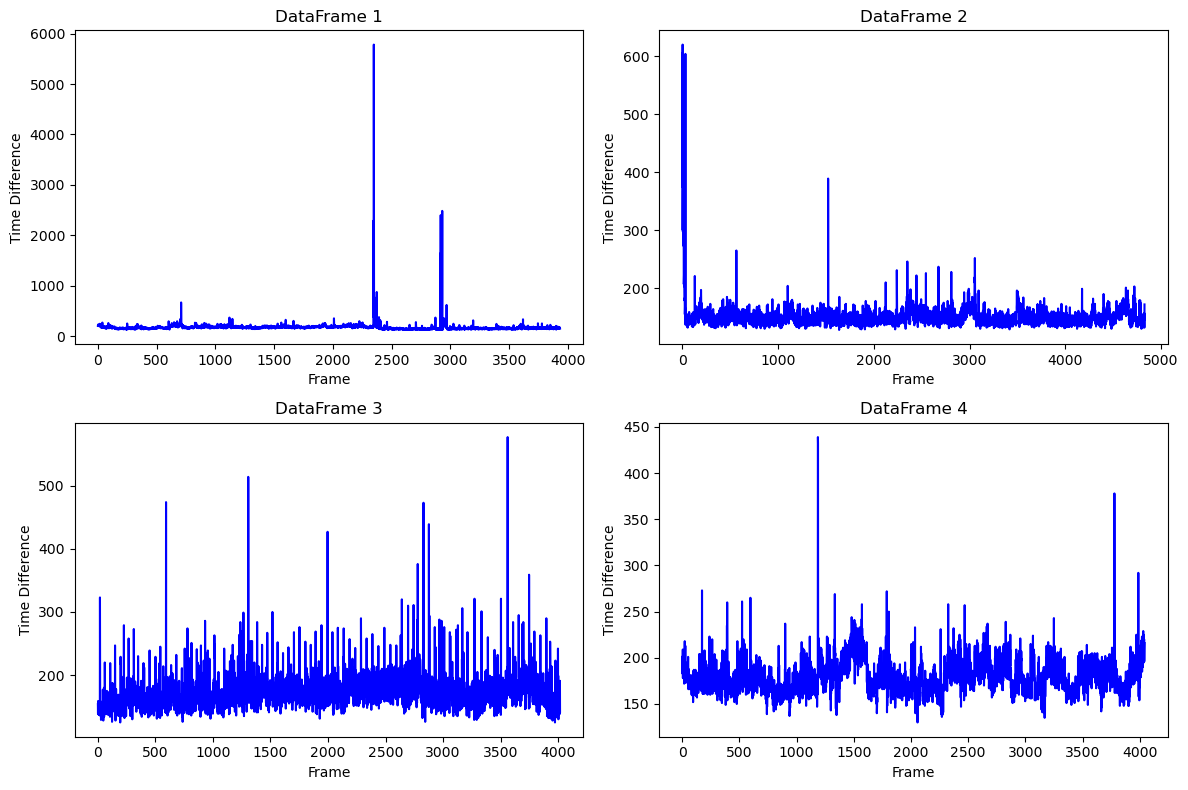

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

# Iterate over DataFrames and plot NearTouches
for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
    # df['c_roll'].plot(ax=axes[i])
    df_filtered = df.dropna(subset=['MS_rating'])
    df['tt']= df['timestamp']-df['timestamp'].shift(1)
    # df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    # df['le_yaw'].plot(ax=axes[i], color='orange')
    # df['re_pitch'].plot(ax=axes[i], color='blue')
    df['tt'].plot(ax=axes[i], color='blue')
    # df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Time Difference')
    # axes[i].set_ylim(-5, 5)

plt.tight_layout()
plt.show()

In [1]:
# Try sampling: take mean/median over aggregating specific time interval

In [31]:
other_data_df=df_fin1[['timestamp','text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll', 'diff_HE_pitch']]
other_data_df['timestamp'] = pd.to_datetime(other_data_df['timestamp'])

In [32]:
other_data_df.set_index('timestamp', inplace=True)

In [33]:
other_data_resampled = other_data_df.resample('100ms').interpolate()

In [34]:
other_data_resampled

,text_presence,change in brightness,diff_HE_yaw,diff_HE_roll,diff_HE_pitch
timestamp,,,,,
1970-01-01 00:28:16,NaN,NaN,NaN,NaN,NaN


In [35]:
#camera movement

In [4]:
df_fin1.columns

Index(['frame', 'timestamp', 'head_dir', 'head_pos', 'head_vel', 'head_angvel',
       'left_eye_dir', 'left_eye_pos', 'left_eye_vel', 'left_eye_angvel',
       ...
       'c_y', 'c_z', 'c_speed', 'c_velocity', 'c_acceleration',
       'text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll',
       'diff_HE_pitch'],
      dtype='object', length=109)

In [28]:
df=df_fin1
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [29]:
df['timestamp']

0      2023-09-30 08:17:32.784
1      2023-09-30 08:17:32.994
2      2023-09-30 08:17:33.220
3      2023-09-30 08:17:33.424
4      2023-09-30 08:17:33.660
                 ...          
3928   2023-09-30 08:29:22.406
3929   2023-09-30 08:29:22.579
3930   2023-09-30 08:29:22.736
3931   2023-09-30 08:29:22.909
3932   2023-09-30 08:29:23.065
Name: timestamp, Length: 3933, dtype: datetime64[ns]

In [30]:
# Calculate the elapsed time since the start
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
start_timestamp = df['timestamp'].min()
df['elapsed_seconds'] = (df['timestamp'] - start_timestamp).dt.total_seconds()

# Calculate the second interval
interval_seconds = 1  # 1 second in milliseconds

# Group by the elapsed seconds rounded to the nearest second
grouped = df.groupby((df['elapsed_seconds'] / interval_seconds).astype(int))

# Calculate median for each group
median_values = grouped.median()

# print(median_values)

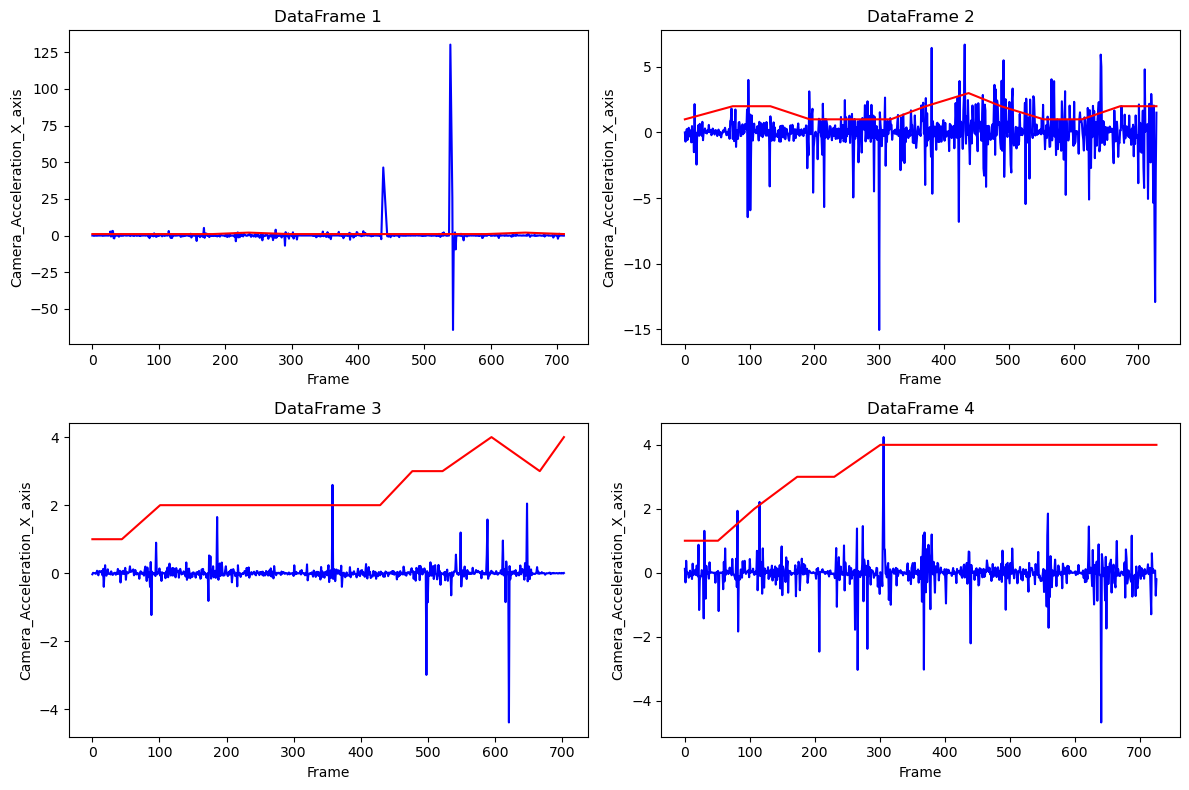

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

# Iterate over DataFrames and plot NearTouches
for i, df1 in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
    # df['c_roll'].plot(ax=axes[i])
    df=df1.copy()
    # Calculate the elapsed time since the start
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    start_timestamp = df['timestamp'].min()
    df['elapsed_seconds'] = (df['timestamp'] - start_timestamp).dt.total_seconds()
    # Calculate the second interval
    interval_seconds = 1  # 1 second in milliseconds
    # Group by the elapsed seconds rounded to the nearest second
    df['c_acceleration']= df['c_acceleration'].apply(lambda x: ast.literal_eval(x))
    # df_fin1['c_acceleration'] = df_fin1['c_acceleration'].apply(lambda x: [0, 0, 0] if pd.isna(x) else x)
    data_expanded = pd.DataFrame(df['c_acceleration'].tolist(), index=df.index)

    # Rename the columns if desired
    data_expanded.columns = ['c_acc1', 'c_acc2', 'c_acc3']
    df = df.drop(columns=['c_acceleration']).join(data_expanded)

    grouped = df.groupby((df['elapsed_seconds'] / interval_seconds).astype(int))

    # Calculate median for each group
    df = grouped.median()
    df_filtered = df.dropna(subset=['MS_rating'])
    # df['tt']= df['timestamp']-df['timestamp'].shift(1)
    # df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    # df['le_yaw'].plot(ax=axes[i], color='orange')
    # df['re_pitch'].plot(ax=axes[i], color='blue')
    df['c_acc1_0']=df['c_acc3']/50
    df['c_acc1_0'].plot(ax=axes[i], color='blue')
    df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Camera_Acceleration_X_axis')
    # axes[i].set_ylim(-5, 5)

plt.tight_layout()
plt.show()

In [2]:
# Try expanding the vectorly saved models: c_acceleration and c_velocity

In [48]:
df_fin1['c_acceleration']

0                                               [0, 0, 0]
1       [-188.95484422610193, -89.52073769774837, -0.8...
2       [-151.938329120451, 10.595629328862053, 10.987...
3       [98.7117463677265, -39.67977285840209, 37.2275...
4       [174.6393697915608, 76.27014454943256, -22.411...
                              ...                        
3928    [-1149.9504928013328, -84.59340522501438, 422....
3929    [1167.5705482642559, 108.09637116067977, -438....
3930    [8.853601117161006, -8.311603093624885, -2.235...
3931    [4.706845588209573, -6.693674167372935, -0.274...
3932    [3.54328210534532, 8.260640684742931, -5.90162...
Name: c_acceleration, Length: 3933, dtype: object

In [19]:
df_fin1.columns

Index(['frame', 'timestamp', 'head_dir', 'head_pos', 'head_vel', 'head_angvel',
       'left_eye_dir', 'left_eye_pos', 'left_eye_vel', 'left_eye_angvel',
       ...
       'c_y', 'c_z', 'c_speed', 'c_velocity', 'c_acceleration',
       'text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll',
       'diff_HE_pitch'],
      dtype='object', length=109)

In [20]:
# df_fin1['c_acceleration']= df_fin1['c_acceleration'].apply(lambda x: ast.literal_eval(x))
# df_fin1['c_acceleration'] = df_fin1['c_acceleration'].apply(lambda x: [0, 0, 0] if pd.isna(x) else x)
data_expanded = pd.DataFrame(df_fin1['c_acceleration'].tolist(), index=df_fin1.index)

# Rename the columns if desired
data_expanded.columns = ['c_acc1', 'c_acc2', 'c_acc3']
df_fin1 = df_fin1.drop(columns=['c_acceleration']).join(data_expanded)


NameError: name 'df' is not defined

In [21]:
df_fin1 = df_fin1.drop(columns=['c_acceleration']).join(data_expanded)

In [9]:
def vector_div3(df,feature):
    f1=feature + '_x'
    f2=feature + '_y'
    f3=feature + '_z'
    L_f1, L_f2, L_f3=[], [], []
    list1=df[feature].to_list()
    for i in list1:
        L_f1.append(i[0])
        L_f2.append(i[1])
        L_f3.append(i[2])
    print(L_f1)        

In [3]:
with open('/home/dinithi/vr-motion-sickness-modelling/Data_Pre_Processing/Econ/games_used.json', 'r') as f:
    games = json.load(f)

# One session -> One data point

In [3]:
# make the dataset1 script

In [69]:
#save the sessions that have the datafile in it
session={}
for i in games.keys():
    for j in games[i]:
        path=os.path.join('/data/VR_NET/folders/', i, j, 'data_file_2.csv')
        if os.path.isfile(path):
            # print("File exists")
            if i not in session.keys():
                session[i]=[]
            session[i].append(j)
file_path='/home/dinithi/vr-motion-sickness-modelling/sharedFolder/sessions.json'
with open(file_path, 'w') as json_file:
    json.dump(session, json_file)

NameError: name 'games' is not defined

In [10]:
df=df_fin1.copy()
# df_without_B = df.drop(columns=['MS_rating','confidence','is_valid','bounds','m_matrix', ])
# columns_with_nan = df_without_B.isnull().any()
# columns_with_nan[20:30]

In [51]:
df[0:1]['MS_rating']

0   NaN
Name: MS_rating, dtype: float64

In [ ]:
# 'IndTrig_L', 'IndTrig_R', 'HandTrig_L',
#        'HandTrig_R', 'Thumb_L', 'Thumb_R', 'Thumb_L_x', 'Thumb_R_x',
#        'Thumb_L_y', 'Thumb_R_y', 'le_roll', 'le_pitch', 'le_yaw', 'LE_speed',
#        'LE_pos_change', 're_roll', 're_pitch', 're_yaw', 'RE_speed', 'RE_pos_change',
#         'h_roll', 'h_pitch', 'h_yaw', 'h_p1', 'h_p2', 'h_p3', 'Head_Speed',
#        'Head_pos_change', 'Head_Velocity_Change',
#        'Head_AngVel_Change', 'c_roll', 'c_pitch',
#        'c_yaw', 'c_speed',
#        'text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll',
#        'diff_HE_pitch', 'c_acceleration1', 'c_acceleration2', 'c_acceleration3', 'c_velocity1',
#        'c_velocity2', 'c_velocity3']

what I have to do to get the session wise median
1. get the first and the last ratings and disregard the rest: done
2. extract the needed columns and make sure they are numerical: done
3. check for nans and do something
4. get the median
5. attribute the max ms rating and get the results

In [2]:
def expand_cols(df, column_name):
    df[column_name]= df[column_name].apply(lambda x: ast.literal_eval(x))
    data_expanded = pd.DataFrame(df[column_name].tolist(), index=df.index)
    data_expanded.columns = [column_name+'1', column_name+'2', column_name+'3']
    df = df.drop(columns=[column_name]).join(data_expanded)
    return df

In [11]:
df1=expand_cols(df,'c_acceleration')
df2=expand_cols(df1,'c_velocity')

In [74]:
df3=df2[['IndTrig_L', 'IndTrig_R', 'HandTrig_L',
       'HandTrig_R', 'Thumb_L', 'Thumb_R', 'Thumb_L_x', 'Thumb_R_x',
       'Thumb_L_y', 'Thumb_R_y', 'le_roll', 'le_pitch', 'le_yaw', 'LE_speed',
       'LE_pos_change', 're_roll', 're_pitch', 're_yaw', 'RE_speed', 'RE_pos_change',
        'h_roll', 'h_pitch', 'h_yaw', 'h_p1', 'h_p2', 'h_p3', 'Head_Speed',
       'Head_pos_change', 'Head_Velocity_Change',
       'Head_AngVel_Change', 'c_roll', 'c_pitch',
       'c_yaw', 'c_speed',
       'text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll',
       'diff_HE_pitch', 'c_acceleration1', 'c_acceleration2', 'c_acceleration3', 'c_velocity1',
       'c_velocity2', 'c_velocity3']]

In [13]:
aggre={
'IndTrig_L' : 'sum',
'IndTrig_R' : 'sum',
'HandTrig_L' : 'sum',
'HandTrig_R' : 'sum',
# 'Thumb_L' : 'median'
# 'Thumb_R' : 'median'
'Thumb_L_x' : 'sum',
'Thumb_R_x' : 'sum',
'Thumb_L_y' : 'sum',
'Thumb_R_y' : 'sum',
'le_roll' : 'median_change',
'le_pitch' : 'median_change',
'le_yaw' : 'median_change',
'LE_speed' : 'median' ,
# 'LE_pos_change' : 'median'
# 're_roll' : 'median'
# 're_pitch' : 'median'
# 're_yaw' : 'median'
# 'RE_speed' : 'median'
# 'RE_pos_change' : 
'h_roll' : 'median_change',
'h_pitch' : 'median_change',
'h_yaw' : 'median_change',
# 'h_p1' : 
# 'h_p2' : 
# 'h_p3' : 
'Head_Speed' : 'median' ,
# 'Head_pos_change' : 
'Head_Velocity_Change' : 'median' ,
'Head_AngVel_Change' : 'median',
'c_roll' : 'median_change',
'c_pitch' : 'median_change',
'c_yaw' : 'median_change',
'c_speed' : 'median',
'text_presence' : 'sum',
'change in brightness' : 'sum',
'diff_HE_yaw' : 'median',
'diff_HE_roll' : 'median',
'diff_HE_pitch' : 'median',
'c_acceleration1' : 'median',
'c_acceleration2' : 'median',
'c_acceleration3' : 'median',
'c_velocity1' : 'median',
'c_velocity2' : 'median',
'c_velocity3' : 'median'}

In [20]:
for i in aggre.keys():
    if aggre[i]=='median':
        aggre[i]='max'

In [13]:
# median
change=[]
for i in aggre.keys():
    if aggre[i]=='median_change':
        change.append(i)
        aggre.pop(i)
        aggre[i+'_change']='median'

# def aggregation(aggre, df):
#     for i in aggre.keys():
#         if aggre[i]=='median_change':
#             change

In [20]:
sessions={'Arena_Clash': ['52_1_Arena_Clash',
  '50_2_Arena_Clash',
  '46_2_Arena_Clash']}

In [59]:
count=0
cleaned_dfs=[]
for i in sessions.keys():
    # logger.info(f'***************{i}********************')
    for j in sessions[i]:
        # logger.info(f'*******{j}********')
        path=os.path.join('/data/VR_NET/folders/', i, j, 'data_file_2.csv')
        df1=pd.read_csv(path)
        df=df1.copy()
        # try:
        msr=df1['MS_rating'].dropna().max()
        aggre1=aggre.copy()
        df=aggregate_df(df, aggre1) 
        df['msr']=msr
        df['session']=j
        # cleaned_dfs.append(df)
        if count==0:
            dfs=df.copy()
        else:
            df_c=[dfs,df]
            dfs = pd.concat(df_c, ignore_index=True)
        # session_saving[count]=path
        count+=1
            # logger.info('*******successfully saved********')
        # except:
        #     logger.info('*******failed********')
# panel_df = pd.concat(cleaned_dfs, ignore_index=True)

Index(['frame', 'timestamp', 'head_dir', 'head_pos', 'head_vel', 'head_angvel',
       'left_eye_dir', 'left_eye_pos', 'left_eye_vel', 'left_eye_angvel',
       ...
       'c_velocity3', 'le_roll_change', 'le_pitch_change', 'le_yaw_change',
       'h_roll_change', 'h_pitch_change', 'h_yaw_change', 'c_roll_change',
       'c_pitch_change', 'c_yaw_change'],
      dtype='object', length=122)
Index(['frame', 'timestamp', 'head_dir', 'head_pos', 'head_vel', 'head_angvel',
       'left_eye_dir', 'left_eye_pos', 'left_eye_vel', 'left_eye_angvel',
       ...
       'c_velocity3', 'le_roll_change', 'le_pitch_change', 'le_yaw_change',
       'h_roll_change', 'h_pitch_change', 'h_yaw_change', 'c_roll_change',
       'c_pitch_change', 'c_yaw_change'],
      dtype='object', length=122)
Index(['frame', 'timestamp', 'head_dir', 'head_pos', 'head_vel', 'head_angvel',
       'left_eye_dir', 'left_eye_pos', 'left_eye_vel', 'left_eye_angvel',
       ...
       'c_velocity3', 'le_roll_change', 'le_pitch_c

In [60]:
dfs

,IndTrig_L,IndTrig_R,HandTrig_L,HandTrig_R,Thumb_L_x,Thumb_R_x,Thumb_L_y,Thumb_R_y,LE_speed,Head_Speed,...,le_pitch_change,le_yaw_change,h_roll_change,h_pitch_change,h_yaw_change,c_roll_change,c_pitch_change,c_yaw_change,msr,session
0,0.0000000000,1.2808302641,6.3743558526,4.0000000000,-1.5212643973,-0.8386872533,-3.4432552441,-0.5306142649,0.0375344653,0.0383184807,...,0.0032543865,0.0018035112,0.0009065301,0.0004666676,0.0017824654,0.0000717206,0.0007139110,0.0028059206,1.0000000000,52_1_Arena_Clash
1,11.0908412933,281.8124368191,816.6026291251,2153.4871490002,88.1168824950,8.8294250794,-80.7441775012,-9.0088537249,0.0280975072,0.0272184307,...,0.0001695295,0.0007603803,-0.0011859391,-0.0005410830,0.0005398648,0.0000000000,0.0003108163,0.0004684923,3.0000000000,50_2_Arena_Clash
2,54.5958479047,372.3963259459,279.6319522858,284.8825368881,39.1976340286,12.0462972541,6.3521554664,-6.2017296353,0.0203076713,0.0201338988,...,-0.0006848047,0.0003605743,-0.0004468064,0.0001715434,0.0000225490,0.0000000000,0.0001084671,0.0000000000,2.0000000000,46_2_Arena_Clash


In [61]:
dfs.to_csv('data/dummy.csv', index=False)

In [23]:
combined_df = pd.DataFrame()
# df1=[combined_df, df]

combined = pd.concat([combined_df, df], axis=0)

In [34]:
dfs.index

Index(['IndTrig_L', 'IndTrig_R', 'HandTrig_L', 'HandTrig_R', 'Thumb_L_x',
       'Thumb_R_x', 'Thumb_L_y', 'Thumb_R_y', 'LE_speed', 'Head_Speed',
       'Head_Velocity_Change', 'Head_AngVel_Change', 'c_speed',
       'text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll',
       'diff_HE_pitch', 'c_acceleration1', 'c_acceleration2',
       'c_acceleration3', 'c_velocity1', 'c_velocity2', 'c_velocity3',
       'le_roll_change', 'le_pitch_change', 'le_yaw_change', 'h_roll_change',
       'h_pitch_change', 'h_yaw_change', 'c_roll_change', 'c_pitch_change',
       'c_yaw_change', 'msr'],
      dtype='object')

In [32]:
datas=pd.read_csv('/home/dinithi/vr-motion-sickness-modelling/sharedFolder/data/dataset1.csv')

In [35]:
Index=['IndTrig_L', 'IndTrig_R', 'HandTrig_L', 'HandTrig_R', 'Thumb_L_x',
       'Thumb_R_x', 'Thumb_L_y', 'Thumb_R_y', 'LE_speed', 'Head_Speed',
       'Head_Velocity_Change', 'Head_AngVel_Change', 'c_speed',
       'text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll',
       'diff_HE_pitch', 'c_acceleration1', 'c_acceleration2',
       'c_acceleration3', 'c_velocity1', 'c_velocity2', 'c_velocity3',
       'le_roll_change', 'le_pitch_change', 'le_yaw_change', 'h_roll_change',
       'h_pitch_change', 'h_yaw_change', 'c_roll_change', 'c_pitch_change',
       'c_yaw_change', 'msr']

In [54]:
def aggregate_df(df,aggre):
    df1=expand_cols(df,'c_acceleration')
    df2=expand_cols(df1,'c_velocity')
    change=[]
    for i in aggre.keys():
        if aggre[i]=='median_change':
            change.append(i)
            aggre.pop(i)
            aggre[i+'_change']='median'
    df=change_diff(df2,change)
    print(df.columns)
    aggregated_df = df.agg(aggre)
    return pd.DataFrame(aggregated_df).transpose()


In [12]:
# check dataset1.py for the code

In [53]:
pd.DataFrame(df).transpose()

,IndTrig_L,IndTrig_R,HandTrig_L,HandTrig_R,Thumb_L_x,Thumb_R_x,Thumb_L_y,Thumb_R_y,LE_speed,Head_Speed,...,le_pitch_change,le_yaw_change,h_roll_change,h_pitch_change,h_yaw_change,c_roll_change,c_pitch_change,c_yaw_change,msr,session
0,54.5958479047,372.3963259459,279.6319522858,284.8825368881,39.1976340286,12.0462972541,6.3521554664,-6.2017296353,0.0203076713,0.0201338988,...,-0.0006848047,0.0003605743,-0.0004468064,0.0001715434,0.0000225490,0.0000000000,0.0001084671,0.0000000000,2.0000000000,46_2_Arena_Clash


# Unsupervised TSNE

In [3]:
path_to_data='data/dataset1.csv'
data=pd.read_csv(path_to_data)

In [7]:
data.drop(['session'], inplace=True, axis=1)

In [11]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [49]:
# X = data.iloc[:, :-1].values
# y = data.iloc[:, -1].values  # Assuming the last column is the target variable

# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply t-SNE
# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X_scaled)

# # Plot the results
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
# plt.colorbar(scatter)
# plt.title('t-SNE of Tabular Data')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.show()

In [19]:
game_name=data1['session']

In [24]:
game_n=[]
for i in game_name:
    parts = i.split('_')
    result = '_'.join(parts[2:])
    game_n.append(result)
    

In [27]:
unique_games = list(set(game_n))
game_to_number = {game: i for i, game in enumerate(unique_games)}

In [36]:
print(game_to_number)

{'Army_Men': 0, 'City_Parkour': 1, 'Zombie': 2, 'Creature_Feature': 3, 'American_Idol': 4, 'Bobber_Bay_Fishing': 5, 'Metdonalds': 6, 'Wake_the_Robot': 7, '3D_Play_House': 8, 'Geometry_Gunners': 9, 'Citadel': 10, 'Scifi_Sandbox': 11, 'Arena_Clash': 12, 'Waffle_Restaurant': 13, 'The_aquarium': 14, 'Roommate': 15, 'Kowloon': 16, 'Venues': 17, 'Earth_Gym': 18, 'Superhero_Arena': 19, 'Pirate_Life': 20, 'VR_Classroom': 21, 'Super_Rumble': 22, 'Titanic_Simulation': 23, 'Mars_Miners': 24, 'Kawaii_Daycare': 25, 'Horizon_Boxing': 26, 'Canyon_Runners': 27, 'Wild_Quest': 28, 'UFO_crash_site_venue': 29, 'Barnyard': 30, 'Out_Of_Control': 31, 'Giant_Paddle_Golf': 32, 'Slash_RPG': 33}


In [28]:
numbered_games = [game_to_number[game] for game in game_n]

In [30]:
data['session']=numbered_games

In [48]:
# from matplotlib.colors import ListedColormap

# X = data.iloc[:, :-2].values
# y = data.iloc[:, -1].values  # Assuming the last column is the target variable

# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply t-SNE
# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X_scaled)

# colors = plt.cm.get_cmap('tab20', 20).colors
# extra_colors = plt.cm.get_cmap('tab20c', 13).colors
# all_colors = np.vstack((colors, extra_colors[:13]))

# cmap = ListedColormap(all_colors)
# # Plot the results
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=cmap)
# plt.colorbar(scatter)
# plt.title('t-SNE of Tabular Data')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.show()

In [33]:
max(numbered_games)

33

### Correlation

In [21]:
# data=data.drop(['session'], axis=1)
# correlation_matrix = data.corr()

# # Print the correlation matrix
# print(correlation_matrix)

# # Plot the heatmap
# plt.figure(figsize=(30, 30))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
# plt.title('Correlation Matrix of Tabular Data')
# plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
# plt.show()
 
#LE_Speed, Head_Speed, Head_Velocity_Change, Head_AngVel_Change is highly correlated, so will use Head_Speed instead

In [8]:
data.columns

Index(['IndTrig_L', 'IndTrig_R', 'HandTrig_L', 'HandTrig_R', 'Thumb_L_x',
       'Thumb_R_x', 'Thumb_L_y', 'Thumb_R_y', 'LE_speed', 'Head_Speed',
       'Head_Velocity_Change', 'Head_AngVel_Change', 'c_speed',
       'text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll',
       'diff_HE_pitch', 'c_acceleration1', 'c_acceleration2',
       'c_acceleration3', 'c_velocity1', 'c_velocity2', 'c_velocity3',
       'le_roll_change', 'le_pitch_change', 'le_yaw_change', 'h_roll_change',
       'h_pitch_change', 'h_yaw_change', 'c_roll_change', 'c_pitch_change',
       'c_yaw_change', 'msr'],
      dtype='object')

In [5]:
data.drop(['Head_Speed', 'Head_Velocity_Change', 'Head_AngVel_Change'],inplace=True, axis=1)

In [6]:
data

,IndTrig_L,IndTrig_R,HandTrig_L,HandTrig_R,Thumb_L_x,Thumb_R_x,Thumb_L_y,Thumb_R_y,LE_speed,c_speed,...,le_pitch_change,le_yaw_change,h_roll_change,h_pitch_change,h_yaw_change,c_roll_change,c_pitch_change,c_yaw_change,msr,session
0,307.0857128501,1964.1880280375,479.9325641394,773.7249817848,112.7772324500,11.4940545838,14.0077421981,7.5250256519,0.0579647316,5.3098304616,...,0.0000289809,-0.0000918342,-0.0018050308,-0.0001443211,0.0000049136,-0.0001891249,0.0002238403,0.0011997346,1.0000000000,5_2_Earth_Gym
1,16.9663001299,2430.5513986945,1.9709395766,1455.0678274035,70.3901673191,0.9440431309,-5.2594380988,0.1427961193,0.0505247473,5.9245356343,...,-0.0010772048,-0.0003741525,0.0002469212,-0.0006883928,-0.0012896073,-0.0037681528,0.0006144616,0.0026818000,3.0000000000,10_2_Earth_Gym
2,112.8376043439,1254.5750874877,3061.0642033219,1005.0646598339,24.7821736269,-8.2420312519,-45.8027589538,9.7083087195,0.0433299661,4.7678445710,...,0.0000000000,0.0000000000,0.0008398293,0.0007479872,-0.0000912995,-0.0010748638,0.0004726954,0.0013010263,5.0000000000,8_2_Earth_Gym
3,4.7643460631,1114.3372384906,1.1057386994,209.4671146870,14.6815510347,-1.9604496902,50.2692683331,0.2821773636,0.0420991319,6.3089233741,...,0.0001274842,-0.0002629745,-0.0002223732,-0.0001127280,0.0001258433,-0.0011308392,-0.0001089609,0.0008258046,3.0000000000,7_1_Earth_Gym
4,277.2380945086,1783.4454193711,20.3164761662,54.5738664865,38.7230776689,6.8585755045,65.6174961058,-19.3326962152,0.0315949075,4.7723553808,...,-0.0013547837,0.0000122526,0.0000018736,-0.0005738171,0.0001448593,-0.0004749522,-0.0001181314,-0.0001622484,3.0000000000,9_1_Earth_Gym
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,10.6454173923,528.0898481607,868.9938133359,1507.3835915327,-133.3878359844,-13.0160827208,-9.4919577008,-5.1006689638,0.0303644148,4.7915203691,...,-0.0010966713,0.0000026449,-0.0008641560,-0.0000755859,-0.0000016774,0.0000067511,-0.0006002474,-0.0005101188,3.0000000000,153_1_Creature_Feature
244,2.4024417996,408.6041405797,0.9218551517,20.8761877418,0.5985212915,-0.6325236308,23.6274585348,-3.7910130150,0.0155380319,1.3646978614,...,-0.0006335537,-0.0001391621,-0.0004128756,-0.0001600864,0.0001155400,0.0006655896,-0.0001768334,0.0000420512,2.0000000000,154_1_Creature_Feature
245,105.3391916156,276.9509037733,3997.9711410403,4595.0568879247,-141.2153503569,19.0820182535,-130.4644375154,-16.6100105321,0.0229965061,3.8731125396,...,0.0005211996,-0.0002003000,-0.0005006005,-0.0004938538,-0.0000715233,0.0003246645,-0.0001409826,-0.0002255202,3.0000000000,155_2_Creature_Feature
246,0.0000000000,184.1338148713,14.5877802372,93.0324519873,28.4869056383,-5.8780443623,-50.1528238119,-0.6216793522,0.0254569286,4.3367778241,...,-0.0003547013,0.0001419329,0.0004173953,-0.0000480072,0.0000259492,-0.0001853362,0.0000437992,0.0002534642,3.0000000000,151_1_Creature_Feature


# Regression

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for clean output
warnings.filterwarnings('ignore')

# Load your data
# Assuming you have a CSV file with your data
# data = pd.read_csv('your_data.csv')

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models and their parameters for grid search
models = {
    'RandomForest': RandomForestRegressor(),
    # 'GradientBoosting': GradientBoostingRegressor(),
    # 'SVR': SVR()
}

params = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf']
    }
}

# Perform grid search with cross-validation for each model
best_models = {}
for name in models:
    grid_search = GridSearchCV(models[name], params[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate the best models on the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Test MSE: {mse}")

Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 100}
RandomForest Test MSE: 1.5333200000000002


In [33]:
y_pred

array([2.7 , 1.18, 3.81, 2.73, 3.01, 2.82, 3.69, 4.78, 3.14, 3.15, 3.64,
       2.98, 2.24, 2.  , 1.46, 2.82, 3.57, 2.24, 2.56, 4.75, 2.9 , 4.78,
       1.7 , 4.66, 3.16, 4.24, 3.23, 4.62, 2.91, 3.56])

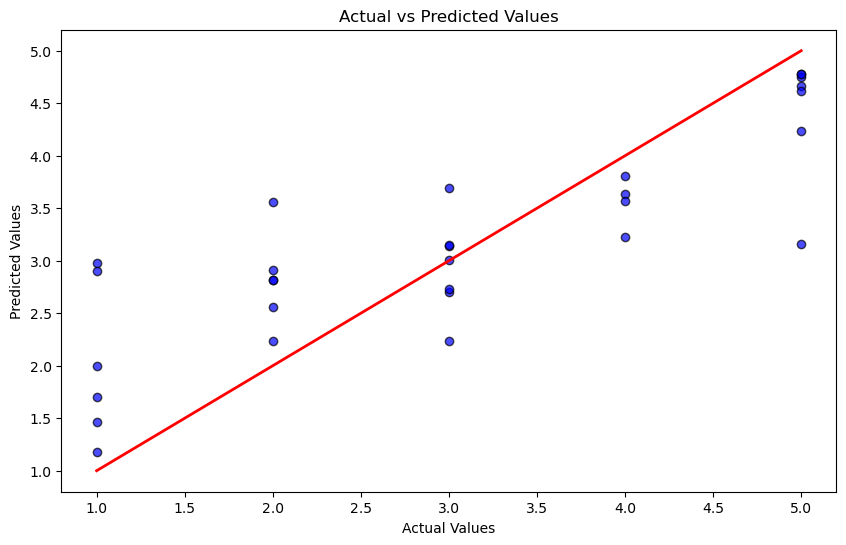

In [34]:
# Plot y_pred vs y_test
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [14]:
data['msr'].value_counts()

2.0000000000    76
3.0000000000    55
1.0000000000    47
4.0000000000    39
5.0000000000    31
Name: msr, dtype: int64

# Gradient Boosting

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
# import catboost as cb
import warnings

In [17]:
len(data.columns)

31

In [38]:
# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split, model, and evaluate as shown above
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models and their parameters for grid search
models = {
    # 'LightGBM': lgb.LGBMRegressor(),
    'XGBoost': xgb.XGBRegressor()
    # 'CatBoost': cb.CatBoostRegressor(verbose=0)
}

params = {
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200, 400],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'CatBoost': {
        'iterations': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [3, 5, 7]
    }
}

# Perform grid search with cross-validation for each model
best_models = {}
for name in models:
    grid_search = GridSearchCV(models[name], params[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate the best models on the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Test MSE: {mse}")


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
XGBoost Test MSE: 0.8563397962890799


In [14]:
# Best parameters for LightGBM: {'learning_rate': 0.01, 'n_estimators': 50, 'num_leaves': 31}
# Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
# LightGBM Test MSE: 1.5550943382585887
# XGBoost Test MSE: 1.7516378066489182

# Best parameters for LightGBM: {'learning_rate': 0.01, 'n_estimators': 50, 'num_leaves': 31}
# Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
# LightGBM Test MSE: 1.5084503901261042
# XGBoost Test MSE: 1.753595214649647

# MLP

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for clean output
warnings.filterwarnings('ignore')

# Load your data
# Assuming you have a CSV file with your data
# data = pd.read_csv('motion_sickness_data.csv')

# Display the first few rows of the data
print(data.head())

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the MLPRegressor and its parameters for grid search
mlp = MLPRegressor(max_iter=500)

params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_mlp_model = grid_search.best_estimator_
print(f"Best parameters for MLP: {grid_search.best_params_}")

# Evaluate the best MLP model on the test set
y_pred = best_mlp_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MLP Test MSE: {mse}")


         IndTrig_L       IndTrig_R      HandTrig_L     HandTrig_R  \
193  25.7626370788   46.3970686197  202.2783195972 304.3051645756   
138 129.1653233767 3288.3663000464   60.3069344759  36.5208690166   
56    0.0000000000    0.0000000000    0.0000000000   0.0000000000   
209 698.4925489426  914.5159915686  665.3636004329 219.4490669370   
38   67.7465195656  402.7526225448 3515.9359939098 393.1168541908   

         Thumb_L_x     Thumb_R_x      Thumb_L_y      Thumb_R_y   Head_Speed  \
193 -76.8422265247 -5.4186478082 -17.4468223506 -13.7456960511 0.0367410745   
138  30.5994141818  4.8519836933 -14.0130482494  -1.6711434972 0.0219786274   
56    3.3809635543  0.0000000000   0.7286365660   0.0000000000 0.0569498433   
209  15.1149035507 -0.8089851155  -0.0337055786   7.3306578257 0.0327574589   
38  158.8370407969 -9.6896111916   9.4893647425   2.0431653371 0.0343622294   

          c_speed  ...  le_roll_change  le_pitch_change  le_yaw_change  \
193  5.7788213506  ...    0.00043646

In [4]:
# Balancing Data

In [9]:
# Function to randomly select 30 samples from each class
def balance_classes(data, target_column, samples_per_class=30):
    balanced_data = pd.DataFrame()
    
    # Group the data by the target column
    grouped = data.groupby(target_column)
    
    # For each class, randomly sample 'samples_per_class' samples
    for class_label, group in grouped:
        sampled_group = group.sample(n=samples_per_class, random_state=42, replace=True)  # 'replace=True' if the class has less than 'samples_per_class' samples
        balanced_data = pd.concat([balanced_data, sampled_group])
    
    return balanced_data

# Apply the function
balanced_data = balance_classes(data, target_column='msr', samples_per_class=30)

In [10]:
balanced_data

,IndTrig_L,IndTrig_R,HandTrig_L,HandTrig_R,Thumb_L_x,Thumb_R_x,Thumb_L_y,Thumb_R_y,LE_speed,c_speed,...,le_roll_change,le_pitch_change,le_yaw_change,h_roll_change,h_pitch_change,h_yaw_change,c_roll_change,c_pitch_change,c_yaw_change,msr
193,25.7626370788,46.3970686197,202.2783195972,304.3051645756,-76.8422265247,-5.4186478082,-17.4468223506,-13.7456960511,0.0370998316,5.7788213506,...,0.0004364615,-0.0014845310,-0.0000820041,-0.0006721032,-0.0008935061,0.0000838196,-0.0006830008,0.0004440317,-0.0007635973,1.0000000000
138,129.1653233767,3288.3663000464,60.3069344759,36.5208690166,30.5994141818,4.8519836933,-14.0130482494,-1.6711434972,0.0214010857,7.8241475324,...,-0.0014640363,-0.0018092527,-0.0000455181,-0.0018575682,-0.0010861577,-0.0001573783,-0.0002166831,0.0001662392,0.0004179767,1.0000000000
56,0.0000000000,0.0000000000,0.0000000000,0.0000000000,3.3809635543,0.0000000000,0.7286365660,0.0000000000,0.0601259100,5.7387113153,...,-0.0150231500,-0.0062805416,0.0032012365,0.0018161816,0.0021314096,0.0024192859,-0.0041984316,0.0022673816,0.0004836488,1.0000000000
209,698.4925489426,914.5159915686,665.3636004329,219.4490669370,15.1149035507,-0.8089851155,-0.0337055786,7.3306578257,0.0326373240,1.1234951047,...,-0.0019081233,-0.0000692015,-0.0003666953,-0.0004531940,-0.0003368471,0.0002539946,0.0000794719,-0.0002504308,-0.0000295411,1.0000000000
38,67.7465195656,402.7526225448,3515.9359939098,393.1168541908,158.8370407969,-9.6896111916,9.4893647425,2.0431653371,0.0342527816,19.3871869894,...,-0.0003573985,-0.0007136740,-0.0000936164,-0.0005492686,-0.0002504394,-0.0001970570,0.0004169010,-0.0003188397,-0.0000440919,1.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,33.8188030720,26.5067150593,30.0412681699,30.7267352939,-31.4839429163,11.0412318893,33.9720723148,9.0618183213,0.0162162413,4.1517587347,...,-0.0004861696,0.0001085631,0.0000175898,-0.0010327099,0.0005692513,-0.0001661594,0.0000000000,0.0000000000,0.0000699054,5.0000000000
59,5.8151390553,229.7628804445,8.2026810646,91.8087891936,26.6930735754,-7.2237255880,-44.1125818517,-7.6830246795,0.0236241686,3.2910372931,...,-0.0010641679,-0.0000357264,-0.0002683604,-0.0001599786,-0.0005966926,-0.0000191604,-0.0001814222,-0.0002616086,0.0002632628,5.0000000000
7,9.8100045323,422.1704486012,1571.9340296388,471.9635841250,65.2592360721,11.0389483864,7.0414881395,-7.6384451754,0.0330738370,5.1197655517,...,-0.0020454870,-0.0000877560,0.0000098001,-0.0004134582,0.0005513570,0.0001451636,-0.0007178444,-0.0000088265,0.0007364706,5.0000000000
212,0.0000000000,150.4876646399,34.5216115713,41.3347976804,-30.5601293335,2.2012644643,3.9361125819,2.9384436960,0.0141160669,32.1074222200,...,-0.0008192815,-0.0001331128,0.0001385982,-0.0006878408,0.0002921890,-0.0000654638,-0.0005254950,-0.0000869702,0.0001604856,5.0000000000


In [12]:
data=balanced_data

In [13]:
# Go ahead with random forest regressor

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for clean output
warnings.filterwarnings('ignore')

# Load your data
# Assuming you have a CSV file with your data
# data = pd.read_csv('your_data.csv')

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models and their parameters for grid search
models = {
    'RandomForest': RandomForestRegressor(),
    # 'GradientBoosting': GradientBoostingRegressor(),
    # 'SVR': SVR()
}

params = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf']
    }
}

# Perform grid search with cross-validation for each model
best_models = {}
for name in models:
    grid_search = GridSearchCV(models[name], params[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate the best models on the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Test MSE: {mse}")

Best parameters for RandomForest: {'max_depth': 20, 'n_estimators': 50}
RandomForest Test MSE: 0.6039200000000001


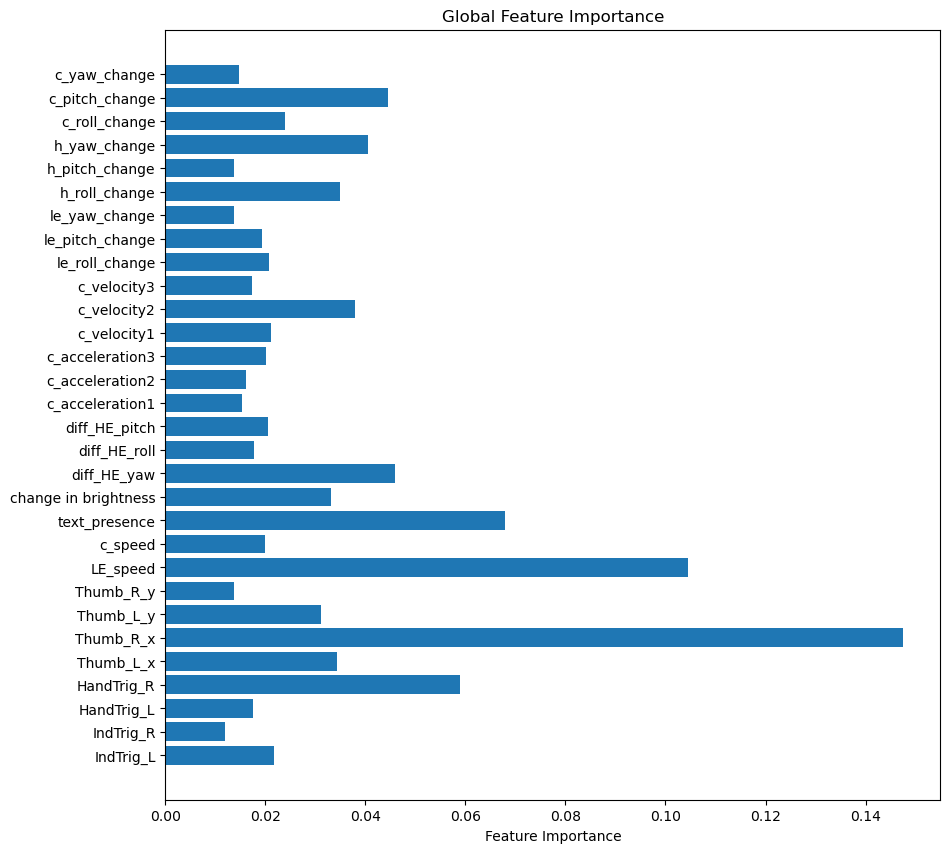

In [62]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# # Train a random forest regressor
# model = RandomForestRegressor()
# model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 10))
plt.barh(range(len(importances)), importances, tick_label=data.columns[:-1])
plt.xlabel('Feature Importance')
plt.title('Global Feature Importance')
plt.show()


# Lime Explainer

In [2]:
# load the saved model
with open('model2.pkl', 'rb') as file:
    model = pickle.load(file)

In [3]:
path_to_data='data/dataset1.csv'
data=pd.read_csv(path_to_data)
data1=data.copy()

In [4]:
data.columns

Index(['IndTrig_L', 'IndTrig_R', 'HandTrig_L', 'HandTrig_R', 'Thumb_L_x',
       'Thumb_R_x', 'Thumb_L_y', 'Thumb_R_y', 'LE_speed', 'Head_Speed',
       'Head_Velocity_Change', 'Head_AngVel_Change', 'c_speed',
       'text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll',
       'diff_HE_pitch', 'c_acceleration1', 'c_acceleration2',
       'c_acceleration3', 'c_velocity1', 'c_velocity2', 'c_velocity3',
       'le_roll_change', 'le_pitch_change', 'le_yaw_change', 'h_roll_change',
       'h_pitch_change', 'h_yaw_change', 'c_roll_change', 'c_pitch_change',
       'c_yaw_change', 'msr', 'session'],
      dtype='object')

In [5]:
path_to_data='data/dataset1.csv'
data=pd.read_csv(path_to_data)
data1=data.copy()
# Extract the needed session ids
df=data1.copy()
df['game_name'] = df['session'].apply(lambda x: "_".join(x.split("_")[2:]))

# Filterthe DataFrame for sessions of 'Arena_Clash'
arena_clash_sessions = df[df['game_name'] == 'Arena_Clash']
arena_clash_sessions

,IndTrig_L,IndTrig_R,HandTrig_L,HandTrig_R,Thumb_L_x,Thumb_R_x,Thumb_L_y,Thumb_R_y,LE_speed,Head_Speed,...,le_yaw_change,h_roll_change,h_pitch_change,h_yaw_change,c_roll_change,c_pitch_change,c_yaw_change,msr,session,game_name
73,0.0000000000,1.2808302641,6.3743558526,4.0000000000,-1.5212643973,-0.8386872533,-3.4432552441,-0.5306142649,0.0375344653,0.0383184807,...,0.0018035112,0.0009065301,0.0004666676,0.0017824654,0.0000717206,0.0007139110,0.0028059206,1.0000000000,52_1_Arena_Clash,Arena_Clash
74,11.0908412933,281.8124368191,816.6026291251,2153.4871490002,88.1168824950,8.8294250794,-80.7441775012,-9.0088537249,0.0280975072,0.0272184307,...,0.0007603803,-0.0011859391,-0.0005410830,0.0005398648,0.0000000000,0.0003108163,0.0004684923,3.0000000000,50_2_Arena_Clash,Arena_Clash
75,54.5958479047,372.3963259459,279.6319522858,284.8825368881,39.1976340286,12.0462972541,6.3521554664,-6.2017296353,0.0203076713,0.0201338988,...,0.0003605743,-0.0004468064,0.0001715434,0.0000225490,0.0000000000,0.0001084671,0.0000000000,2.0000000000,46_2_Arena_Clash,Arena_Clash
76,2.0871783495,810.6358917356,3.7882779241,8.1848583221,-4.7019183836,-5.6189052831,-32.6471080840,-4.3648125700,0.0261987707,0.0265856811,...,0.0000000000,-0.0008032858,-0.0009178802,0.0001144536,-0.0008900679,0.0003414851,0.0001401475,1.0000000000,51_2_Arena_Clash,Arena_Clash
77,8.1137972474,276.3072031736,151.4375844002,371.2021954656,-22.0072854364,-0.2324137853,3.1510336618,4.0868398909,0.0295060259,0.0299074662,...,-0.0002299462,-0.0018726953,-0.0017894292,0.0004482335,-0.0001664665,-0.0000132004,-0.0008705803,3.0000000000,44_1_Arena_Clash,Arena_Clash


In [6]:
# Extract the needed session ids
df=data1.copy()
df['game_name'] = df['session'].apply(lambda x: "_".join(x.split("_")[2:]))

# Filterthe DataFrame for sessions of 'Arena_Clash'
arena_clash_sessions = df[df['game_name'] == 'Arena_Clash']
arena_clash_sessions

,IndTrig_L,IndTrig_R,HandTrig_L,HandTrig_R,Thumb_L_x,Thumb_R_x,Thumb_L_y,Thumb_R_y,LE_speed,Head_Speed,...,le_yaw_change,h_roll_change,h_pitch_change,h_yaw_change,c_roll_change,c_pitch_change,c_yaw_change,msr,session,game_name
73,0.0000000000,1.2808302641,6.3743558526,4.0000000000,-1.5212643973,-0.8386872533,-3.4432552441,-0.5306142649,0.0375344653,0.0383184807,...,0.0018035112,0.0009065301,0.0004666676,0.0017824654,0.0000717206,0.0007139110,0.0028059206,1.0000000000,52_1_Arena_Clash,Arena_Clash
74,11.0908412933,281.8124368191,816.6026291251,2153.4871490002,88.1168824950,8.8294250794,-80.7441775012,-9.0088537249,0.0280975072,0.0272184307,...,0.0007603803,-0.0011859391,-0.0005410830,0.0005398648,0.0000000000,0.0003108163,0.0004684923,3.0000000000,50_2_Arena_Clash,Arena_Clash
75,54.5958479047,372.3963259459,279.6319522858,284.8825368881,39.1976340286,12.0462972541,6.3521554664,-6.2017296353,0.0203076713,0.0201338988,...,0.0003605743,-0.0004468064,0.0001715434,0.0000225490,0.0000000000,0.0001084671,0.0000000000,2.0000000000,46_2_Arena_Clash,Arena_Clash
76,2.0871783495,810.6358917356,3.7882779241,8.1848583221,-4.7019183836,-5.6189052831,-32.6471080840,-4.3648125700,0.0261987707,0.0265856811,...,0.0000000000,-0.0008032858,-0.0009178802,0.0001144536,-0.0008900679,0.0003414851,0.0001401475,1.0000000000,51_2_Arena_Clash,Arena_Clash
77,8.1137972474,276.3072031736,151.4375844002,371.2021954656,-22.0072854364,-0.2324137853,3.1510336618,4.0868398909,0.0295060259,0.0299074662,...,-0.0002299462,-0.0018726953,-0.0017894292,0.0004482335,-0.0001664665,-0.0000132004,-0.0008705803,3.0000000000,44_1_Arena_Clash,Arena_Clash


In [7]:
data1.drop(['c_acceleration1','c_acceleration2','c_acceleration2','c_velocity1','c_velocity2','c_velocity3', 'session','msr','Head_Speed', 'Head_Velocity_Change' , 'Head_AngVel_Change'],inplace=True, axis=1)
data.drop(['c_acceleration1','c_acceleration2','c_acceleration2','c_velocity1','c_velocity2','c_velocity3', 'session','Head_Speed', 'Head_Velocity_Change' , 'Head_AngVel_Change'],inplace=True, axis=1)

In [8]:
data1=data1.abs()
data=data.abs()

In [9]:
# Function to randomly select 30 samples from each class
def balance_classes(data, target_column, samples_per_class=30):
    balanced_data = pd.DataFrame()
    
    # Group the data by the target column
    grouped = data.groupby(target_column)
    
    # For each class, randomly sample 'samples_per_class' samples
    for class_label, group in grouped:
        sampled_group = group.sample(n=samples_per_class, random_state=42, replace=True)  # 'replace=True' if the class has less than 'samples_per_class' samples
        balanced_data = pd.concat([balanced_data, sampled_group])
    
    return balanced_data

# Apply the function
balanced_data = balance_classes(data, target_column='msr', samples_per_class=30)
data=balanced_data

In [10]:
# balanced_data.mxxx/in()

In [11]:
# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error
# import warnings

# # Suppress warnings for clean output
# warnings.filterwarnings('ignore')

# # Load your data
# # Assuming you have a CSV file with your data
# # data = pd.read_csv('your_data.csv')

# # Separate features and target
# X = data.iloc[:, :-1].values
# y = data.iloc[:, -1].values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the models and their parameters for grid search
# models = {
#     'RandomForest': RandomForestRegressor(),
#     # 'GradientBoosting': GradientBoostingRegressor(),
#     # 'SVR': SVR()
# }

# params = {
#     'RandomForest': {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [None, 10, 20]
#     },
#     'GradientBoosting': {
#         'n_estimators': [50, 100, 200],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'max_depth': [3, 5, 7]
#     },
#     'SVR': {
#         'C': [0.1, 1, 10],
#         'gamma': ['scale', 'auto'],
#         'kernel': ['rbf']
#     }
# }

# # Perform grid search with cross-validation for each model
# best_models = {}
# for name in models:
#     grid_search = GridSearchCV(models[name], params[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#     grid_search.fit(X_train, y_train)
#     best_models[name] = grid_search.best_estimator_
#     print(f"Best parameters for {name}: {grid_search.best_params_}")

# # Evaluate the best models on the test set
# for name, model in best_models.items():
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     print(f"{name} Test MSE: {mse}")

In [13]:
# with open('model2.pkl', 'wb') as file:
#     pickle.dump(model, file)

In [14]:
X=data1.iloc[:, :].values

In [18]:
import lime
import lime.lime_tabular

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=data.columns[:-1], class_names=['msr'], mode='regression')

# Explain a single prediction
# i = 0  # Index of the instance to explain
exp = explainer.explain_instance(X[73], model.predict)

# Show explanation
# exp.show_in_notebook(show_all=False)

exp.as_list()

[('text_presence <= 3512.75', 0.6254823905482517),
 ('h_yaw_change > 0.00', -0.6172220875177239),
 ('LE_speed > 0.04', -0.26800068855222425),
 ('diff_HE_pitch <= 0.07', -0.1313215084032416),
 ('Thumb_R_y <= 1.57', -0.1174791986942602),
 ('0.00 < le_roll_change <= 0.00', 0.09234449914181486),
 ('diff_HE_yaw > 0.03', 0.07879305399277824),
 ('change in brightness <= 14025.21', -0.0764668591167822),
 ('IndTrig_R <= 77.33', -0.07344264640603783),
 ('Thumb_R_x <= 1.57', 0.06734430338667644)]

In [ ]:
# AC1['le_roll_change']

In [115]:
#52_1_Arena_Clash
file='52_1_Arena_Clash'
AC1=pd.read_csv('/data/VR_NET/folders/Arena_Clash/'+file+'/data_file_2.csv')
list1=AC1[abs(AC1['diff_HE_yaw']) > 0.03]['frame'].to_list()

ind=0
start=[]
end=[]
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])
arr1=[]
for i in range(len(start)):
    arr1.append('diff_HE_yaw')

    
AC1['le_roll_change']=abs(AC1['le_roll']-AC1['le_roll'].shift(1))
# list1=AC1[AC1['le_roll_change'] == 0.00]['frame'].to_list()
list1=AC1[(AC1['le_roll_change'] > 0.000) & (AC1['le_roll_change'] <= 0.01)]['frame'].to_list()

ind=0
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])

for i in range(len(start)-len(arr1)):
    arr1.append('le_roll')

In [116]:
start, end , arr1

([57940, 58520, 58830, 59140, 57950, 58260, 58640, 59040],
 [58240, 58820, 59130, 59440, 58250, 58560, 58940, 59340],
 ['diff_HE_yaw',
  'diff_HE_yaw',
  'diff_HE_yaw',
  'diff_HE_yaw',
  'le_roll',
  'le_roll',
  'le_roll',
  'le_roll'])

In [117]:
df = pd.DataFrame({
    'Start': start,
    'End': end,
    'Reason': arr1
})

print(df)

df.to_csv(file+'.csv')

   Start    End       Reason
0  57940  58240  diff_HE_yaw
1  58520  58820  diff_HE_yaw
2  58830  59130  diff_HE_yaw
3  59140  59440  diff_HE_yaw
4  57950  58250      le_roll
5  58260  58560      le_roll
6  58640  58940      le_roll
7  59040  59340      le_roll


In [19]:
len(list1)

1072

In [20]:
len(AC1)

4216

In [43]:
exp = explainer.explain_instance(X[74], model.predict, num_features=20)

# Show explanation
# exp.show_in_notebook()

exp.as_list()

[('h_yaw_change > 0.00', -0.6320611654595746),
 ('3893.00 < text_presence <= 4448.50', -0.241116816330321),
 ('Thumb_R_y > 8.97', 0.08574969129375838),
 ('diff_HE_roll <= 0.10', -0.07892117299220751),
 ('0.01 < diff_HE_yaw <= 0.02', -0.07776131273194896),
 ('0.00 < h_pitch_change <= 0.00', 0.07157133281351931),
 ('le_roll_change <= 0.00', -0.05769526271995944),
 ('0.03 < LE_speed <= 0.04', 0.05407981424892821),
 ('3.91 < c_speed <= 5.76', -0.05314402319908295),
 ('le_yaw_change > 0.00', 0.047082902690663085),
 ('0.00 < c_yaw_change <= 0.00', 0.045327441020844315),
 ('Thumb_L_y > 36.88', 0.03735369293772019),
 ('le_pitch_change <= 0.00', 0.03516176714085261),
 ('14025.21 < change in brightness <= 21536.61', -0.03327354136063254),
 ('Thumb_L_x > 53.90', 0.03287404510471207),
 ('5.25 < Thumb_R_x <= 9.53', -0.028625982991717463),
 ('0.00 < c_pitch_change <= 0.00', -0.02674190332810298),
 ('h_roll_change > 0.00', 0.023482579384634765),
 ('HandTrig_R > 1294.23', 0.021771456543230257),
 ('0.0

In [118]:
#50_2_Arena_Clash
file='50_2_Arena_Clash'
AC1=pd.read_csv('/data/VR_NET/folders/Arena_Clash/'+file+'/data_file_2.csv')
# list1=AC1[AC1['LE_speed'] > 0.04]['frame'].to_list()
AC1['h_pitch_change']=abs(AC1['h_pitch']-AC1['h_pitch'].shift(1))
list1=AC1[(AC1['h_pitch_change'] > 0.00000) & (AC1['h_pitch_change'] <= 0.0001)]['frame'].to_list()

ind=0
start=[]
end=[]
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])
arr1=[]
for i in range(len(start)):
    arr1.append('h_pitch')

    
# AC1['c_pitch_change']=AC1['c_pitch']-AC1['c_pitch'].shift(1)
# list1=AC1[abs(AC1['Thumb_L_x']) > 53.90]['frame'].to_list()
AC1['c_yaw_change']=abs(AC1['c_yaw']-AC1['c_yaw'].shift(1))
list1=AC1[(AC1['c_yaw_change'] > 0.0) & (AC1['c_yaw_change'] <= 0.0001)]['frame'].to_list()


ind=0
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])

for i in range(len(start)-len(arr1)):
    arr1.append('c_yaw')

In [119]:
arr1

['h_pitch',
 'h_pitch',
 'h_pitch',
 'h_pitch',
 'h_pitch',
 'h_pitch',
 'h_pitch',
 'h_pitch',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw',
 'c_yaw']

In [32]:
# AC1['c_yaw_change']

In [53]:
# frames=list1

In [54]:
# start=[]
# end=[]
# current=frames[0]
# starti=frames[0]
# count=0
# for i in frames:
#     if count==1:
#         starti=i
#         count=0
#     if i-current<200:
#         endi=current
#     else:
#         endi= current
#         end.append(endi)
#         start.append(starti)
#         count=1
#     current=i
    
        
    

In [55]:
# start, end, arr1

In [36]:
# list1

In [37]:
len(start)

226

In [39]:
# start, end , arr1

In [34]:
len(start)

226

In [120]:
df = pd.DataFrame({
    'Start': start,
    'End': end,
    'Reason': arr1
})

print(df)

df.to_csv(file+'.csv')

    Start    End   Reason
0    5470   5770  h_pitch
1    7190   7490  h_pitch
2    9170   9470  h_pitch
3   16490  16790  h_pitch
4   17820  18120  h_pitch
5   22160  22460  h_pitch
6   27790  28090  h_pitch
7   39190  39490  h_pitch
8    4500   4800    c_yaw
9    9900  10200    c_yaw
10  13970  14270    c_yaw
11  19220  19520    c_yaw
12  23860  24160    c_yaw
13  28280  28580    c_yaw
14  28610  28910    c_yaw
15  29330  29630    c_yaw
16  29840  30140    c_yaw
17  35020  35320    c_yaw
18  39020  39320    c_yaw
19  41720  42020    c_yaw
20  42140  42440    c_yaw


In [40]:
exp = explainer.explain_instance(X[75], model.predict,num_features=20)

# Show explanation
# exp.show_in_notebook()

exp.as_list()

[('h_yaw_change <= 0.00', 0.26648314938072515),
 ('3893.00 < text_presence <= 4448.50', -0.2313093819182072),
 ('LE_speed <= 0.02', 0.13591268078756918),
 ('change in brightness > 35324.01', 0.1293417388594966),
 ('h_pitch_change <= 0.00', -0.10742030537193795),
 ('diff_HE_pitch > 0.10', 0.0704204292220556),
 ('0.01 < diff_HE_yaw <= 0.02', -0.06638157775314031),
 ('4.35 < Thumb_R_y <= 8.97', 0.06237822258754103),
 ('Thumb_R_x > 9.53', -0.05961514243051024),
 ('3.91 < c_speed <= 5.76', -0.04290788967888853),
 ('0.00 < le_roll_change <= 0.00', 0.03525671516024978),
 ('57.75 < HandTrig_R <= 352.91', 0.033123071016930496),
 ('0.00 < le_yaw_change <= 0.00', -0.028897388626783628),
 ('c_yaw_change <= 0.00', 0.02751789381859848),
 ('0.00 < c_pitch_change <= 0.00', 0.022119138391468),
 ('c_acceleration3 <= 0.00', 0.02043350593736587),
 ('0.10 < diff_HE_roll <= 0.13', 0.019572409685482937),
 ('27.58 < Thumb_L_x <= 53.90', 0.017927839001309922),
 ('40.11 < IndTrig_L <= 165.48', -0.01617589745561

In [123]:
#46_2_Arena_Clash
file='46_2_Arena_Clash'
AC1=pd.read_csv('/data/VR_NET/folders/Arena_Clash/'+file+'/data_file_2.csv')
AC1['h_yaw_change']=abs(AC1['h_yaw']-AC1['h_yaw'].shift(1))
list1=AC1[AC1['h_yaw_change'] <= 0.00001]['frame'].to_list()
# AC1['h_yaw_change']=abs(AC1['h_pitch']-AC1['h_pitch'].shift(1))
# list1=AC1[(AC1['h_pitch_change'] > 0.001) & (AC1['h_pitch_change'] <= 0.01)]['frame'].to_list()

ind=0
start=[]
end=[]
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])
arr1=[]
for i in range(len(start)):
    arr1.append('h_yaw')

    
# AC1['c_pitch_change']=AC1['c_pitch']-AC1['c_pitch'].shift(1)
list1=AC1[abs(AC1['LE_speed']) <= 0.0005]['frame'].to_list()
# AC1['LE_speed']=abs(AC1['c_yaw']-AC1['c_yaw'].shift(1))
# list1=AC1[(AC1['c_yaw_change'] > 0.001) & (AC1['c_yaw_change'] <= 0.01)]['frame'].to_list()


ind=0
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])

for i in range(len(start)-len(arr1)):
    arr1.append('LE_speed')

In [124]:
arr1

['h_yaw', 'h_yaw', 'h_yaw', 'h_yaw', 'h_yaw', 'LE_speed', 'LE_speed']

In [76]:
# start, end , arr1

In [125]:
df = pd.DataFrame({
    'Start': start,
    'End': end,
    'Reason': arr1
})

print(df)

df.to_csv(file+'.csv')

   Start    End    Reason
0   5630   5930     h_yaw
1   9920  10220     h_yaw
2  13790  14090     h_yaw
3  33570  33870     h_yaw
4  40950  41250     h_yaw
5   5420   5720  LE_speed
6   9190   9490  LE_speed


In [78]:
exp = explainer.explain_instance(X[76], model.predict)

# Show explanation
# exp.show_in_notebook()

exp.as_list()

[('0.00 < h_yaw_change <= 0.00', 0.21753270624780816),
 ('3512.75 < text_presence <= 3893.00', -0.15990023221097308),
 ('0.02 < LE_speed <= 0.03', 0.14429488131538373),
 ('change in brightness > 35324.01', 0.10902432001562055),
 ('4.35 < Thumb_R_y <= 8.97', 0.0863456674575245),
 ('HandTrig_R <= 57.75', -0.07538414712324658),
 ('0.00 < h_roll_change <= 0.00', 0.05570331017014071),
 ('0.01 < diff_HE_yaw <= 0.02', -0.05166441440384651),
 ('0.07 < diff_HE_pitch <= 0.08', 0.051217756136538214),
 ('IndTrig_L <= 4.76', 0.0453910184193559)]

In [129]:
#51_2_Arena_Clash
file='51_2_Arena_Clash'
AC1=pd.read_csv('/data/VR_NET/folders/Arena_Clash/'+file+'/data_file_2.csv')
AC1['h_yaw_change']=abs(AC1['h_yaw']-AC1['h_yaw'].shift(1))
# list1=AC1[AC1['h_yaw_change'] == 0.00]['frame'].to_list()
# AC1['h_yaw_change']=abs(AC1['h_pitch']-AC1['h_pitch'].shift(1))
list1=AC1[(AC1['h_yaw_change'] > 0.000000) & (AC1['h_yaw_change'] <= 0.00001)]['frame'].to_list()

ind=0
start=[]
end=[]
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])
arr1=[]
for i in range(len(start)):
    arr1.append('h_yaw')

    
# AC1['c_pitch_change']=AC1['c_pitch']-AC1['c_pitch'].shift(1)
# list1=AC1[abs(AC1['LE_speed']) > 0.02]['frame'].to_list()
# AC1['LE_speed']=abs(AC1['c_yaw']-AC1['c_yaw'].shift(1))
# h_yaw_change
AC1['LE_speed']=abs(AC1['LE_speed'])
list1=AC1[(AC1['LE_speed'] >  0.0249) & (AC1['LE_speed'] <= 0.0251)]['frame'].to_list()


ind=0
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])

for i in range(len(start)-len(arr1)):
    arr1.append('LE_speed')

In [130]:
# start, end , arr1
arr1

['h_yaw',
 'h_yaw',
 'h_yaw',
 'h_yaw',
 'h_yaw',
 'LE_speed',
 'LE_speed',
 'LE_speed',
 'LE_speed',
 'LE_speed',
 'LE_speed',
 'LE_speed',
 'LE_speed']

In [131]:
df = pd.DataFrame({
    'Start': start,
    'End': end,
    'Reason': arr1
})

print(df)

df.to_csv(file+'.csv')

    Start    End    Reason
0    4100   4400     h_yaw
1    5910   6210     h_yaw
2    6850   7150     h_yaw
3   27880  28180     h_yaw
4   36920  37220     h_yaw
5    5260   5560  LE_speed
6   11250  11550  LE_speed
7   13640  13940  LE_speed
8   14560  14860  LE_speed
9   18050  18350  LE_speed
10  22710  23010  LE_speed
11  26330  26630  LE_speed
12  28600  28900  LE_speed


In [84]:
exp = explainer.explain_instance(X[77], model.predict,num_features=20)

# Show explanation
# exp.show_in_notebook()

exp.as_list()

[('text_presence <= 3512.75', 0.6200086571998501),
 ('h_yaw_change > 0.00', -0.6192751584088956),
 ('diff_HE_pitch <= 0.07', -0.1600350116318295),
 ('diff_HE_yaw <= 0.01', -0.12417221769722768),
 ('Thumb_R_x <= 1.57', 0.07031649420539643),
 ('le_roll_change > 0.00', -0.06311482336724858),
 ('c_pitch_change <= 0.00', 0.06262167141129231),
 ('c_yaw_change > 0.00', -0.06008804403050922),
 ('0.00 < le_yaw_change <= 0.00', -0.05454323969411064),
 ('change in brightness <= 14025.21', -0.04696479616881932),
 ('h_pitch_change > 0.00', -0.0398771367007316),
 ('diff_HE_roll <= 0.10', -0.034033175873460095),
 ('0.00 < c_roll_change <= 0.00', 0.03296481891832616),
 ('8.04 < Thumb_L_x <= 27.58', -0.026960909816218313),
 ('352.91 < HandTrig_R <= 1294.23', 0.026754543125966153),
 ('Thumb_L_y <= 6.32', -0.024956261345573594),
 ('h_roll_change > 0.00', 0.023560043518365496),
 ('5.76 < c_speed <= 17.19', 0.0230673849298812),
 ('0.00 < le_pitch_change <= 0.00', -0.021995800773374753),
 ('1.57 < Thumb_R_y

In [132]:
#44_1_Arena_Clash
file='44_1_Arena_Clash'
AC1=pd.read_csv('/data/VR_NET/folders/Arena_Clash/'+file+'/data_file_2.csv')
# AC1['h_yaw_change']=abs(AC1['h_yaw']-AC1['h_yaw'].shift(1))
# list1=AC1[AC1['h_yaw_change'] > 0.00]['frame'].to_list()
AC1['c_pitch_change']=abs(AC1['c_pitch']-AC1['c_pitch'].shift(1))
list1=AC1[AC1['c_pitch_change'] < 0.0001]['frame'].to_list()
# AC1['h_yaw_change']=abs(AC1['h_pitch']-AC1['h_pitch'].shift(1))
# list1=AC1[(AC1['h_yaw_change'] > 0.001) & (AC1['h_yaw_change'] <= 0.01)]['frame'].to_list()

ind=0
start=[]
end=[]
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])
arr1=[]
for i in range(len(start)):
    arr1.append('c_pitch')

    
AC1['c_roll_change']=abs(AC1['c_roll']-AC1['c_roll'].shift(1))
# list1=AC1[AC1['c_pitch_change'] > 0.00]['frame'].to_list()
# AC1['LE_speed']=abs(AC1['c_yaw']-AC1['c_yaw'].shift(1))
# h_yaw_change
# AC1['LE_speed']=abs(AC1['LE_speed'])
list1=AC1[(AC1['c_roll_change'] > 0.0000) & (AC1['c_roll_change'] <= 0.0005)]['frame'].to_list()


ind=0
for i in range(len(list1)):
    start1=list1[ind]
    end1=start1+300
    if list1[i]>end1:
        ind=i
        start.append(start1)
        end.append(end1)
    # if i==len(list1)-1:
    #     start.append(start1)
    #     end.append(list1[i])

for i in range(len(start)-len(arr1)):
    arr1.append('c_roll')

In [19]:
# start, end , arr1
# arr1

In [134]:
df = pd.DataFrame({
    'Start': start,
    'End': end,
    'Reason': arr1
})

print(df)

df.to_csv(file+'.csv')

    Start    End   Reason
0    7200   7500  c_pitch
1    8640   8940  c_pitch
2   10650  10950  c_pitch
3    3720   4020   c_roll
4    4230   4530   c_roll
5    5520   5820   c_roll
6    6000   6300   c_roll
7    7500   7800   c_roll
8    7850   8150   c_roll
9    9670   9970   c_roll
10  10810  11110   c_roll
11  13090  13390   c_roll


In [ ]:
start, end , arr1

In [18]:
model.predict(X_train)

array([1.26, 2.  , 2.92, 1.28, 2.46, 4.22, 1.94, 1.44, 1.52, 2.34, 4.54,
       3.04, 2.94, 1.58, 1.6 , 3.04, 4.66, 4.88, 3.14, 3.98, 3.68, 3.98,
       2.94, 1.34, 4.78, 3.08, 2.58, 2.26, 2.06, 3.08, 4.26, 1.92, 1.34,
       1.18, 3.64, 1.94, 3.82, 3.58, 2.04, 3.12, 3.7 , 2.36, 4.52, 3.64,
       3.12, 2.82, 4.78, 2.04, 1.18, 3.6 , 3.72, 2.44, 2.16, 3.04, 2.98,
       2.04, 4.3 , 2.  , 2.38, 2.9 , 3.88, 4.52, 2.86, 4.52, 5.  , 3.  ,
       1.9 , 1.34, 4.  , 4.88, 2.  , 1.26, 2.04, 3.04, 4.44, 1.34, 3.42,
       3.96, 1.04, 3.08, 2.42, 4.78, 2.46, 3.7 , 2.7 , 3.76, 2.86, 4.54,
       2.98, 2.36, 3.56, 2.06, 2.2 , 3.82, 2.68, 3.32, 3.68, 4.66, 1.74,
       2.2 , 4.42, 4.18, 2.66, 4.22, 1.98, 1.92, 4.42, 4.  , 3.88, 3.28,
       3.26, 2.72, 4.56, 5.  , 1.78, 2.9 , 3.96, 1.28, 3.54, 3.96])

In [19]:
import numpy as np

# Sample array
# array = np.array([1.2, 2.5, 3.7, 4.1, 5.9])

# Round the array to the nearest integer
rounded_array = np.round(model.predict(X_train))

# Print the rounded array
print("Rounded array:", rounded_array)

Rounded array: [1. 2. 3. 1. 2. 4. 2. 1. 2. 2. 5. 3. 3. 2. 2. 3. 5. 5. 3. 4. 4. 4. 3. 1.
 5. 3. 3. 2. 2. 3. 4. 2. 1. 1. 4. 2. 4. 4. 2. 3. 4. 2. 5. 4. 3. 3. 5. 2.
 1. 4. 4. 2. 2. 3. 3. 2. 4. 2. 2. 3. 4. 5. 3. 5. 5. 3. 2. 1. 4. 5. 2. 1.
 2. 3. 4. 1. 3. 4. 1. 3. 2. 5. 2. 4. 3. 4. 3. 5. 3. 2. 4. 2. 2. 4. 3. 3.
 4. 5. 2. 2. 4. 4. 3. 4. 2. 2. 4. 4. 4. 3. 3. 3. 5. 5. 2. 3. 4. 1. 4. 4.]


In [20]:
count=0
for i in range(len(y_train)):
    if y_train[i]==rounded_array[i]:
        count+=1

In [21]:
count

94

In [24]:
len1=len(y_train)

In [27]:
print('Train set Accuracy')
count/len1

Train set Accuracy


0.7833333333333333

In [29]:
rounded_array = np.round(model.predict(X_test))

# Print the rounded array
print("Rounded array:", rounded_array)
count=0
for i in range(len(y_test)):
    if y_test[i]==rounded_array[i]:
        count+=1
len2=len(y_test)
print('Test set Accuracy')
count/len2

Rounded array: [3. 1. 4. 3. 3. 3. 4. 5. 3. 3. 4. 3. 2. 2. 1. 3. 4. 3. 3. 5. 3. 5. 2. 5.
 4. 4. 3. 5. 3. 3.]
Test set Accuracy


0.5666666666666667

# Binary Classifier

In [16]:
path_to_data='data/dataset1.csv'
data=pd.read_csv(path_to_data)
data1=data.copy()
# Extract the needed session ids
df=data1.copy()
df['game_name'] = df['session'].apply(lambda x: "_".join(x.split("_")[2:]))

data1.drop(['c_acceleration1','c_acceleration2','c_acceleration2','c_velocity1','c_velocity2','c_velocity3', 'session','msr','Head_Speed', 'Head_Velocity_Change' , 'Head_AngVel_Change'],inplace=True, axis=1)
data.drop(['c_acceleration1','c_acceleration2','c_acceleration2','c_velocity1','c_velocity2','c_velocity3', 'session','Head_Speed', 'Head_Velocity_Change' , 'Head_AngVel_Change'],inplace=True, axis=1)

data1=data1.abs()
data=data.abs()

# Function to randomly select 30 samples from each class
def balance_classes(data, target_column, samples_per_class=30):
    balanced_data = pd.DataFrame()
    
    # Group the data by the target column
    grouped = data.groupby(target_column)
    
    # For each class, randomly sample 'samples_per_class' samples
    for class_label, group in grouped:
        sampled_group = group.sample(n=samples_per_class, random_state=42, replace=True)  # 'replace=True' if the class has less than 'samples_per_class' samples
        balanced_data = pd.concat([balanced_data, sampled_group])
    
    return balanced_data

# # Apply the function
# balanced_data = balance_classes(data, target_column='msr', samples_per_class=30)
# data=balanced_data

X = data.iloc[:, :-1].values
y = [1 if x >= 3 else 0 for x in data.iloc[:, -1].values]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the labels on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.48
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.62      0.54        24
           1       0.50      0.35      0.41        26

    accuracy                           0.48        50
   macro avg       0.48      0.49      0.47        50
weighted avg       0.48      0.48      0.47        50

Confusion Matrix:
[[15  9]
 [17  9]]


Feature importances: [0.03049143 0.03449925 0.02859226 0.067081   0.05394124 0.02922554
 0.06205734 0.06974903 0.05687534 0.04038566 0.0361691  0.02662442
 0.03617423 0.02079219 0.0363565  0.01617901 0.04019155 0.03157893
 0.03856814 0.05629238 0.04742916 0.07018861 0.01465613 0.02798994
 0.02791162]


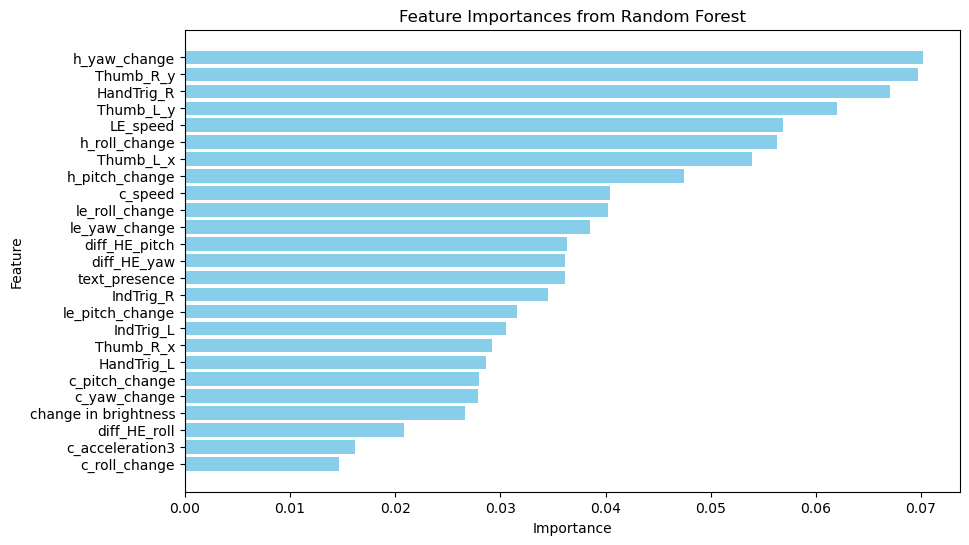

In [13]:
# Get the feature importances
feature_importances = clf.feature_importances_

# Print the feature importances
print("Feature importances:", feature_importances)

# Create a DataFrame for better visualization
features = pd.DataFrame({
    'Feature': data.columns[0:-1],
    'Importance': feature_importances
})

# Sort the features by importance
features = features.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(features['Feature'], features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y axis to have the most important feature at the top
plt.show()

In [12]:
data.columns[0:-1]

Index(['IndTrig_L', 'IndTrig_R', 'HandTrig_L', 'HandTrig_R', 'Thumb_L_x',
       'Thumb_R_x', 'Thumb_L_y', 'Thumb_R_y', 'LE_speed', 'c_speed',
       'text_presence', 'change in brightness', 'diff_HE_yaw', 'diff_HE_roll',
       'diff_HE_pitch', 'c_acceleration3', 'le_roll_change', 'le_pitch_change',
       'le_yaw_change', 'h_roll_change', 'h_pitch_change', 'h_yaw_change',
       'c_roll_change', 'c_pitch_change', 'c_yaw_change'],
      dtype='object')